In [6]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import decomposition
import cv2
import matplotlib
plt.style.use('seaborn-talk')
matplotlib.rcParams.update({'font.size': 15})
# from sklearn.datasets import fetch_mldata

## Toy gaussian data in 2D and basic functions

In [2]:
def gaussian_data(mus, covmats, n):
    """
    Generate gaussian data centered around different means, toy data for testing the algorithms
    
    Params:
        mus (list) : list of means
        covmats (list) : list of numpy.ndarray (the covariance matrixes)
    
    Returns:
        numpy.ndarray : the data stacked in a numpy array, where the last row is the label
    """
    g1 = np.random.multivariate_normal(mus[0], covmats[0], int(n / 2))
    y1 = np.ones((int(n / 2), 1))
    xy1 = np.concatenate((g1, y1), axis=1)
    g2 = np.random.multivariate_normal(mus[1], covmats[1], int((n + 1) / 2))
    y2 = - np.ones((int((n + 1) / 2), 1))
    xy2 = np.concatenate((g2, y2), axis=1)
    xy = np.concatenate((xy1, xy2), axis=0)
    np.random.shuffle(xy)
    return xy                      

In [3]:
def center_and_reduce(xmat, inplace=True):
    """
    Center and reduce data
    
    Params:
        xmat (numpy.ndarray) : the data matrix
        inplace (bool) : should the operation be performed inplace ?
        
    Returns:
        None. If inplace = True
        numpy.ndarray. If inplace= False
    """
    d = xmat.shape[0]
    n = xmat.shape[1]
    xmean = np.mean(xmat, axis=1)
    xvar = np.var(xmat, axis=1)
    meanmat = np.repeat(xmean.reshape((d,1)), n, axis=1)
    varmat = np.repeat(xvar.reshape((d,1)), n, axis=1)
    if inplace :
        xmat = (1 / varmat) * (xmat - meanmat)
    else:
        return (1 / varmat) * (xmat - meanmat)

In [4]:
def data_from_label(xmat, y, label):
    """
    Extract columns in xmat that have the specified label
    
    Params:
        xmats (numpy.ndarray) :  the data matrix
        y (numpy.ndarray) : the corresponding labels vector
        
    Returns:
        numpy.ndarray : the submatrix of xmat corresponding to the labels
    """
    indices = np.argwhere(y == label)
    return xmat[:, indices[:, 0]]

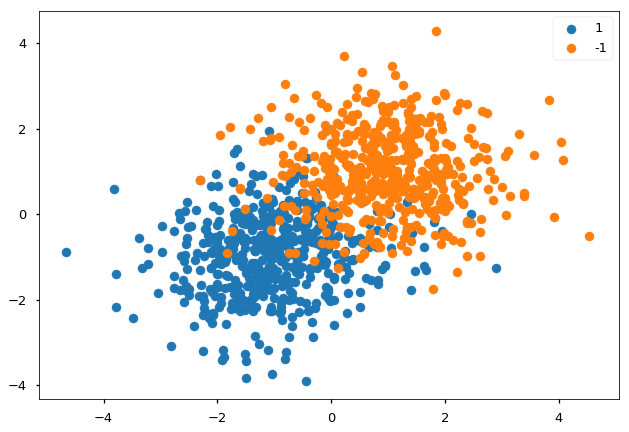

In [7]:
# Parameters for gaussian data
mus = ([-1, -1], [1, 1])
covs = (np.eye(2), np.eye(2))

# Create data
xy = gaussian_data(mus, covs, 1000)

# Separate data and labels
xmat = xy[:, :2].T
y= xy[:,2].T

# Center and reduce
center_and_reduce(xmat)

# Plot
xs_plus1 = data_from_label(xmat, y, 1)
xs_minus1 = data_from_label(xmat, y, -1)
plt.scatter(xs_plus1[0, :], xs_plus1[1, :], label="1")
plt.scatter(xs_minus1[0, :], xs_minus1[1, :], label="-1")
plt.legend()
plt.show()

## Class wrapper for loss functions
We create here an almost empty class model for losses functions (basically a dictionnary of functions). The idea is to be modular in the loss function

In [8]:
class LossFunc:
    
    def __init__(self):
        self.primal = None
        self.dual = None
        self.sdca_update = None
        self.sgd_update = None
        self.pegasos_batch_update = None
    
    def set_primal(self, func):
        """
        Params:
            func (func) : function to set primal class attribute to 
        """
        self.primal = func
    
    def set_dual(self, func):
        """
        Params:
            func (func) : function to set dual class attribute to 
        """
        self.dual = func
    
    def set_sdca_update(self, func):       
        """
        Params:
            func (func) : function to set sdca_update class attribute to 
        """
        self.sdca_update = func
    
    def set_sgd_update(self, func):
        """
        Params:
            func (func) : function to set sgd_update class attribute to 
        """
        self.sgd_update = func
    
    def set_pegasos_batch_update(self, func):
        """
        Params:
            func (func) : function to set pegasos_batch_update class attribute to 
        """
        self.pegasos_batch_update = func

## Definition of Hinge loss using the LossFunc class wrapper
We define the hinge loss using the class framework defined above

In [9]:
def vector_hinge_loss(a, y):
    return np.maximum(0, 1 - y * a)

def vector_hinge_dual(alpha, y):
    prod = alpha * y
    prod[prod > 0] = np.inf
    prod[prod < -1] = np.inf
    return prod

def hinge_delta_alpha(w, xi, yi, alphai, lamb):
    n = xi.shape[0]
    q = lamb * n * (1 - np.dot(xi.T, w) * yi) / np.power(np.linalg.norm(xi), 2)
    q += alphai * yi
    return yi * max(0, min(1, q)) - alphai
    
hinge = LossFunc()
hinge.set_primal(vector_hinge_loss)
hinge.set_dual(vector_hinge_dual)
hinge.set_sdca_update(hinge_delta_alpha)

## Primal and dual of cumulative regularized loss
We define in this section:
1. Some intermediaries functions
1. The primal dual correspondance function (associating w(alpha) to alpha)
1. The primal and dual cumulative loss functions
1. The duality gap function

In [10]:
def xmatT_dot_w(xmat, w):
    return np.dot(xmat.T, w)

In [11]:
def cum_loss(w, xmat, y, lamb, lossfunc=hinge):
    a = xmatT_dot_w(xmat, w)
    cumloss = np.mean(lossfunc.primal(a, y))
    reg = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumloss + reg

In [12]:
def alpha_to_w(alpha, xmat, lamb):
    n = xmat.shape[1]
    return (1 / (n * lamb)) * np.dot(xmat, alpha)

In [13]:
def cum_loss_dual(alpha, xmat, y, lamb, lossfunc=hinge):
    cumlossdual = np.mean(- lossfunc.dual(- alpha, y))
    w = alpha_to_w(alpha, xmat, lamb)
    reg = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumlossdual - reg

In [14]:
# Test for those few first functions
w_test = np.array([1, 1])
w_test = w_test.reshape((2, 1))
a = xmatT_dot_w(w_test, xmat)
h = vector_hinge_loss(a, y)
cumloss = cum_loss(w_test, xmat, y, 1)
n = xmat.shape[1]
alpha_test = 0.5 * np.ones((n,))
cum_loss_dual(alpha_test, xmat, y, 1)

-inf

In [15]:
def duality_gap(alpha, xmat, y, lamb, lossfunc=hinge):
    w = alpha_to_w(alpha, xmat, lamb)
    p = cum_loss(w, xmat, y, lamb, lossfunc)
    d = cum_loss_dual(alpha, xmat, y, lamb, lossfunc)
    return p - d

## Modified SGD for initialization

We wish to find $\alpha_t$ that maximizes : 
$$ - \phi_t^{\star}(-\alpha_t) - \frac{\lambda t}{2} ||w^{(t-1)} + (\lambda t)^{-1} \alpha_t x_t ||^2$$

Let us remark first of all that we must take $\alpha_t$ to be such that $\alpha_t y_t \in [0, 1]$ since if this is not the case, $- \phi_t^{\star}(-\alpha_t) = - \infty$. 

Now supposing that $\alpha_t y_t \in [0, 1]$, developping the previous expression yields : 
$$ \alpha_t y_t - \frac{\lambda t}{2} ( ||w^{(t-1)}||^2 + 2 \frac{\alpha_t}{\lambda t} \langle w^{(t-1)}, x_t \rangle + \frac{\alpha_t^2}{\lambda^2 t^2}||x_t||^2 )$$

This is a second order polynomial in $\alpha_t$. With a negative coefficient on the second order term. Thus this is concave. Setting the derivative to 0 w.r.t $\alpha_t$ yields : 

$$ y_t - \langle w^{(t-1)}, x_t \rangle - \frac{\alpha_t}{\lambda t}||x_t||^2  = 0$$


This gives us an optimal $\alpha_t^{\star}$ which is given by : 
$$ \alpha_t^{\star} = \frac{\lambda t}{||x_t||^2} (y_t - x_t^T w^{(t-1)})$$

Let us now ensure that we threshold this value to make sure that $\alpha_t y_t \in [0, 1]$: The optimal value is thus $\tilde{\alpha_t}$:
\begin{eqnarray*}
    \tilde{\alpha_t} &=& \alpha_t^{\star} ~if~\alpha_t^{\star} y_t \in [0, 1] \\
    \tilde{\alpha_t} &=& \min(0, y_t)~if~\alpha_t^{\star} < \min(0, y_t)\\
    \tilde{\alpha_t} &=& \max(0, y_t)~if~\alpha_t^{\star} > \max(0, y_t)\\
\end{eqnarray*}

In [16]:
def hinge_sgd_update(w, xt, yt, lamb, t):
    wdotx = np.dot(xt.T, w)
    xsqrnorm = np.power(np.linalg.norm(xt), 2)
    val = ((lamb * t) / xsqrnorm) * (yt - wdotx)
    # print(val * yt)
    return min(max(val, min(0, yt)), max(0, yt))
hinge.set_sgd_update(hinge_sgd_update)

In [17]:
def modified_sgd(alpha, w, xmat, y, lamb, lossfunc=hinge):
    n = xmat.shape[1]
    for t in range(0, n):
        alpha[t] = lossfunc.sgd_update(w, xmat[:, t], y[t], lamb, t+1)
        w *= float(t) / float(t + 1)
        w += (1 / (lamb * float(t + 1))) * alpha[t] * xmat[:, t]   
        # w = alpha_to_w(alpha[t], xmat[:, :t+1], lamb)

## Deduction of a classifier

In [18]:
def classify(wstar, xmat_test):
    prod = np.dot(xmat_test.T, wstar)
    prod[prod >= 0] = 1
    prod[prod < 0] = -1
    return prod

In [19]:
def get_score(w, xtest, ytest):
    ypred = classify(w, xtest)
    score = metrics.zero_one_loss(ypred, ytest)
    return score

## SDCA Perm

In [155]:
def sdca_perm_updates(w, alpha, xmat, y, lamb, lossfunc=hinge):
    n = xmat.shape[1]
    inds = np.array(range(0, n))
    np.random.shuffle(inds)
    for j in range(0, n):
        i = inds[j]
        delta = lossfunc.sdca_update(w, xmat[:, i], y[i], alpha[i], lamb)
        alpha[i] += delta
        if (alpha[i] * y[i] < 0) or (alpha[i] * y[i] > 1):
            print (alpha[i])
        w += (1.0 / float(lamb * n)) * delta * xmat[:, i]

In [163]:
def init_tracking(alpha0, xmat, y, lamb, lossfunc, xtest, n):
    
    # Initialize alphas_stacked for tracking alpha's history
    alphas_stacked = alpha0.copy().reshape((n, 1))
    
    # Keep track of the losses
    loss_track = []
    loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
    
    # Keep track of the duality gaps
    gap = duality_gap(alpha0, xmat, y, lamb, lossfunc)
    gaps_track = [gap]
    
    # Initialization of CPU perfs counter
    perfs = [0]
    
    # Keep track of the score on the test set
    if isinstance(xtest, np.ndarray):
        score = get_score(w, xtest, ytest)
        score_test = [score]
        return alphas_stacked, loss_track, gaps_track, perfs, score_test

    return alphas_stacked, loss_track, gaps_track, perfs

In [201]:
def sgd_epoch(alpha, 
              w,
              xmat, 
              y, 
              lamb, 
              lossfunc, 
              xtest, 
              ytest, 
              alphas_stacked, 
              loss_track, 
              gaps_track, 
              perfs, 
              score_test):
    start = time.clock()
    modified_sgd(alpha, w, xmat, y, lamb)
    end = time.clock()
    # Track CPU perfs
    perfs.append(end - start)
    # Track losses
    loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
    # Track duality gap
    gap = duality_gap(alpha, xmat, y, lamb, lossfunc)
    gaps_track.append(gap)
    # Track 0-1 score on test set
    if isinstance(xtest, np.ndarray):
        score = get_score(w, xtest, ytest)
        score_test.append(score)
    n = alpha.shape[0]
    alphas_stacked = np.concatenate((alphas_stacked, alpha.reshape((n, 1))), axis=1)
    return alphas_stacked

In [202]:
def sdca_epoch(alpha, 
               w,
               xmat, 
               y, 
               lamb, 
               lossfunc, 
               xtest, 
               ytest, 
               alphas_stacked, 
               loss_track, 
               gaps_track, 
               perfs, 
               score_test):
    start = time.clock()
    sdca_perm_updates(w, alpha, xmat, y, lamb, lossfunc)
    end = time.clock()
    # Track CPU perfs
    perfs.append(end - start)
    # Track losses
    loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
    # Track duality gap
    gap = duality_gap(alpha, xmat, y, lamb, lossfunc)
    gaps_track.append(gap)
    # Track 0-1 score on test set
    if isinstance(xtest, np.ndarray):
        score = get_score(w, xtest, ytest)
        score_test.append(score)
    n = alpha.shape[0]
    alphas_stacked = np.concatenate((alphas_stacked, alpha.reshape((n, 1))), axis=1)
    return alphas_stacked

In [203]:
def sdca_perm(alpha0, 
              xmat, 
              y, 
              lamb, 
              nepochs, 
              epsilon, 
              lossfunc=hinge, 
              T=0, 
              return_opt=None, 
              sgd_first=True, 
              xtest=None, 
              ytest=None):
    
    # Find out dataset size
    n = xmat.shape[1]
    
    # Work on a copy of alpha0
    alpha = alpha0.copy()
    
    # Initialize w from alpha
    w = alpha_to_w(alpha0, xmat, lamb)
    
    # Initialization of tracking in the case we want to track score on test set
    if isinstance(xtest, np.ndarray):
        alphas_stacked, loss_track, gaps_track, perfs, score_test  = init_tracking(alpha0, xmat, y, lamb, 
                                                                              lossfunc, xtest, n)
    
    # Initialization of tracking in the case we do not want to track score on test set
    else :
        alphas_stacked, loss_track, gaps_track, perfs = init_tracking(alpha0, xmat, y, lamb, 
                                                                      lossfunc, xtest, n)
        score_test=None
        
    # Initialization of epochs counter
    k = 0
    
    # Perform SGD as first epoch if sgd_first is set to True
    if sgd_first :
        alphas_stacked = sgd_epoch(alpha, w, xmat, y, lamb, lossfunc, xtest, ytest, alphas_stacked, 
                                   loss_track, gaps_track, perfs, score_test)
        k += 1
        gap = gaps_track[k]
        
    # Perform the SDCA epochs
    while (gap > epsilon) and (k < nepochs) :
        alphas_stacked = sdca_epoch(alpha, w, xmat, y, lamb, lossfunc, xtest, ytest, alphas_stacked, 
                                    loss_track, gaps_track, perfs, score_test)
        k += 1
        gap = gaps_track[k]
        
    # Return the 
            
    if isinstance(xtest, np.ndarray):
        return w, alpha, alphas_stacked, loss_track, perfs, gaps_track, score_test
    else:
        return w, alpha, alphas_stacked, loss_track, perfs, gaps_track

## Pegasos algorithm (=stochastic subgradient descent)

In [102]:
def hinge_loss_update(w, xmat, y, eta, lamb, batch_indexes):
    k = batch_indexes.shape[0]
    restricted_xmat = xmat[:, batch_indexes]
    restricted_y = y[batch_indexes]
    dot = xmatT_dot_w(restricted_xmat, w)
    indic = (restricted_y * dot < 1).astype(np.int64)
    summed_vec = np.dot(restricted_xmat, restricted_y * indic)
    w *= (1 - eta * lamb)
    w += (float(eta) / float(k)) * summed_vec

hinge.set_pegasos_batch_update(hinge_loss_update)

In [103]:
def pegasos_algorithm(w, xmat, y, lamb, k, nepochs, lossfunc=hinge, xtest=None, ytest=None):
    n = xmat.shape[1]
    loss_track = []
    loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
    t = 1
    perfs = [0]
    if isinstance(xtest, np.ndarray):
        score_test = []
        score = get_score(w, xtest, ytest)
        score_test.append(score)
    for epoch in range(0, nepochs) : 
        start = time.clock()
        indexes = np.array(range(0, n))
        np.random.shuffle(indexes)
        for i in range(0, n // k):
            eta = 1.0 / (float(lamb * t))
            lossfunc.pegasos_batch_update(w, xmat, y, eta, lamb, indexes[i * k : (i + 1) * k])
            t += 1
        end = time.clock()
        perfs.append(end - start)
        loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
        if isinstance(xtest, np.ndarray):
            score = get_score(w, xtest, ytest)
            score_test.append(score)
    if isinstance(xtest, np.ndarray):
        return loss_track, perfs, score_test  
    else : 
        return loss_track, perfs

## Hyperplane plotting function

In [24]:
def hyperplane(w, xgrid):
    return (-w[0] / w[1]) * xgrid

## Test on toy gaussian 2D data

### SDCA vs Pegasos

In [204]:
lamb = 0.1
d = xmat.shape[0]
n = xmat.shape[1]
alpha0 = np.zeros((n, ))
w_pegasos = np.zeros((d, ))

# First epoch using SGD
# alpha0, w0 = modified_sgd(xmat, y, 1)

# SDCA epochs
w_sdca, alpha_sdca, losses_sdca, perfs_sdca, gaps_sdca = sdca_perm(alpha0, xmat, y, lamb, 10, 0.001, sgd_first=True)

# Pegasos
losses_pegasos, perfs_pegasos = pegasos_algorithm(w_pegasos, xmat, y, lamb, 1, 50, lossfunc=hinge)

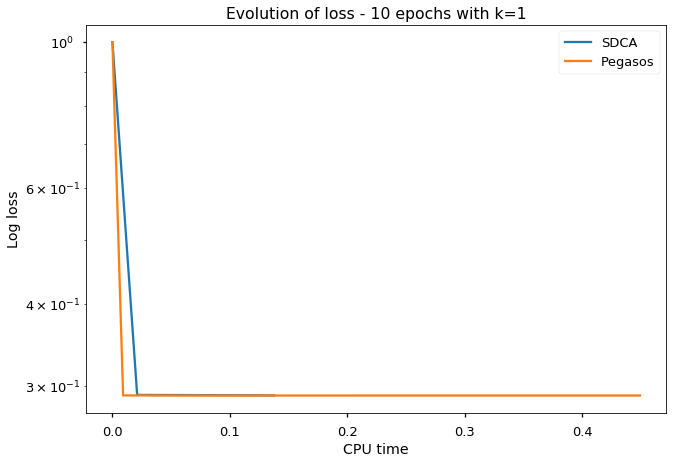

In [206]:
plt.semilogy(np.cumsum(perfs_sdca), losses_sdca, label="SDCA")
plt.semilogy(np.cumsum(perfs_pegasos), losses_pegasos, label="Pegasos")
plt.ylabel("Log loss")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution of loss - 10 epochs with k=1")
plt.show()

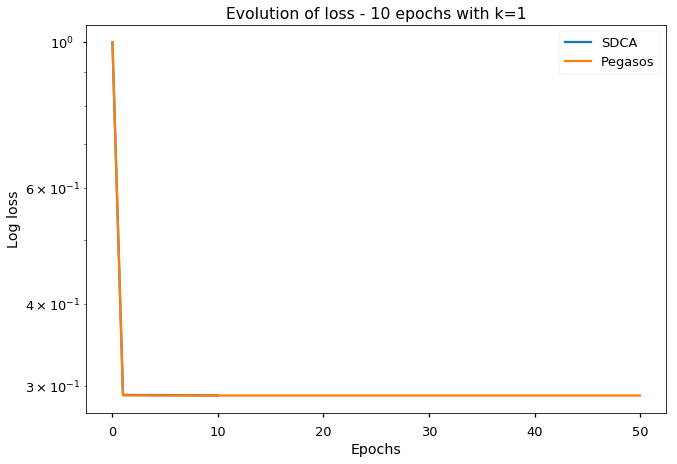

In [207]:
plt.semilogy(losses_sdca, label="SDCA")
plt.semilogy(losses_pegasos, label="Pegasos")
plt.ylabel("Log loss")
plt.xlabel("Epochs")
plt.legend()
plt.title("Evolution of loss - 10 epochs with k=1")
plt.show()

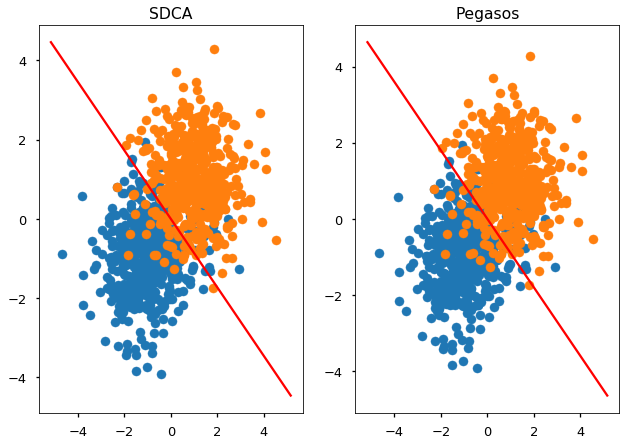

In [28]:
fig, axes = plt.subplots(1, 2)
xs_plus1 = data_from_label(xmat, y, 1)
xs_minus1 = data_from_label(xmat, y, -1)
axes[0].scatter(xs_plus1[0, :], xs_plus1[1, :], label="1")
axes[0].scatter(xs_minus1[0, :], xs_minus1[1, :], label="-1")
axes[1].scatter(xs_plus1[0, :], xs_plus1[1, :], label="1")
axes[1].scatter(xs_minus1[0, :], xs_minus1[1, :], label="-1")
xlim0 = axes[0].get_xlim()
xlim1 = axes[1].get_xlim()
xgrid0 = np.linspace(xlim0[0], xlim0[1], 1000)
xgrid1 = np.linspace(xlim1[0], xlim1[1], 1000)
sep0 = (xgrid0, hyperplane(w_sdca, xgrid0))
sep1 = (xgrid1, hyperplane(w_pegasos, xgrid1))
axes[0].plot(sep0[0], sep0[1], c="r")
axes[1].plot(sep1[0], sep1[1], c="r")
axes[0].set_title("SDCA")
axes[1].set_title("Pegasos")
plt.show()

## Test on blood cells automatic classification

In [29]:
# Load database 
path = os.getcwd() + "/Cropped/"
neutrophils_train = np.loadtxt(path + "neutrophils_train.gz")
lymphocytes_train = np.loadtxt(path + "lymphocytes_train.gz")
neutrophils_test = np.loadtxt(path + "neutrophils_test.gz")
lymphocytes_test = np.loadtxt(path + "lymphocytes_test.gz")

In [30]:
def add_labels(data, label):
    n = data.shape[1]
    y = label * np.ones((1, n))
    data = np.concatenate((data, y))
    return data

In [31]:
# Add labels
neutrophils_train = add_labels(neutrophils_train, 1)
neutrophils_test = add_labels(neutrophils_test, 1)
lymphocytes_train = add_labels(lymphocytes_train, -1)
lymphocytes_test = add_labels(lymphocytes_test, -1)

In [32]:
# Concatenate
data_train =  np.concatenate((neutrophils_train, lymphocytes_train), axis=1)
data_test =  np.concatenate((neutrophils_test, lymphocytes_test), axis=1)
# Shuffle the data
data_train = (np.random.permutation(data_train.T)).T
data_test = (np.random.permutation(data_test.T)).T

In [33]:
# Separate data from labels once shuffled
xtrain = data_train[0:data_train.shape[0] - 1, :]
ytrain = data_train[-1, :]
xtest = data_test[0:data_test.shape[0] - 1, :]
ytest = data_test[-1, :]

In [34]:
# Center and reduce
center_and_reduce(xtrain)
center_and_reduce(xtest)

In [144]:
lamb = 1.6
d = xtrain.shape[0]
n = xtrain.shape[1]
alpha0 = np.zeros((n, ))
w_pegasos = np.zeros((d, ))
nepochs_sdca = 20
nepochs_pegasos = 20
minibatch_pegasos = 100

# SDCA epochs
w_sdca, alpha_sdca, losses_sdca, perfs_sdca, gaps_sdca, scores_sdca = sdca_perm(alpha0, 
                                                                           xtrain, 
                                                                           ytrain, 
                                                                           lamb, 
                                                                           nepochs_sdca, 
                                                                           0.001, 
                                                                           sgd_first=True, 
                                                                          xtest=xtest, 
                                                                          ytest=ytest)
print(np.sum(perfs_sdca))

# Pegasos
losses_pegasos, perfs_pegasos, scores_pegasos= pegasos_algorithm(w_pegasos, xtrain, ytrain, 
                                                   lamb, minibatch_pegasos, nepochs_pegasos, 
                                                   xtest=xtest, ytest=ytest)
print(np.sum(perfs_pegasos))

17.915606
159.354123


In [140]:
# SDCA epochs
w_sdca, alpha_sdca, losses_sdca, perfs_sdca, gaps_sdca, scores_sdca = sdca_perm(alpha0, 
                                                                           xtrain, 
                                                                           ytrain, 
                                                                           lamb, 
                                                                           nepochs_sdca, 
                                                                           0.0001, 
                                                                           sgd_first=True, 
                                                                            xtest=xtest, 
                                                                          ytest=ytest)

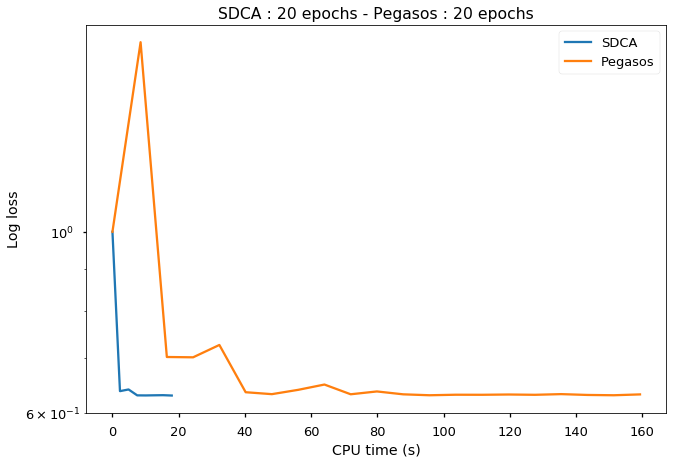

In [145]:
plt.semilogy(np.cumsum(perfs_sdca), losses_sdca, label="SDCA")
plt.semilogy(np.cumsum(perfs_pegasos), losses_pegasos, label="Pegasos")
plt.ylabel("Log loss")
plt.xlabel("CPU time (s)")
plt.legend()
plt.title("SDCA : " + str(nepochs_sdca) + " epochs - Pegasos : " + str(nepochs_pegasos) + " epochs")

output_path = os.getcwd() + "/Graphs/"

# plt.savefig(output_path + "Noisy_Logloss.svg")
plt.show()

In [146]:
ypred = classify(w_sdca, xtest)
print(metrics.zero_one_loss(ypred, ytest))

0.260450160772


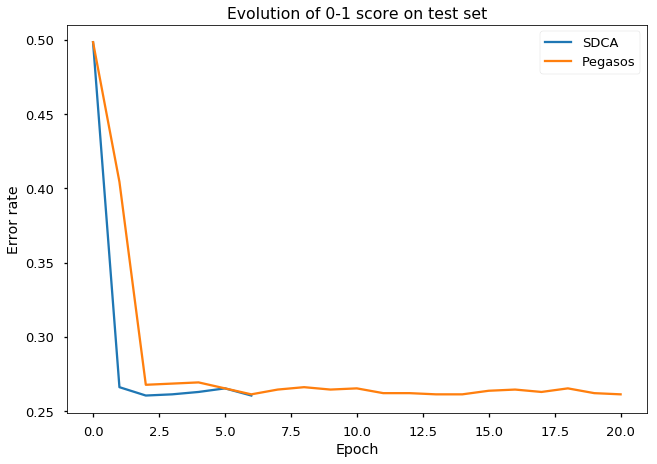

In [147]:
plt.plot(scores_sdca, label="SDCA")
plt.plot(scores_pegasos, label="Pegasos")
plt.title("Evolution of 0-1 score on test set")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error rate")
plt.savefig(output_path + "Noisy_Test_Score.svg")

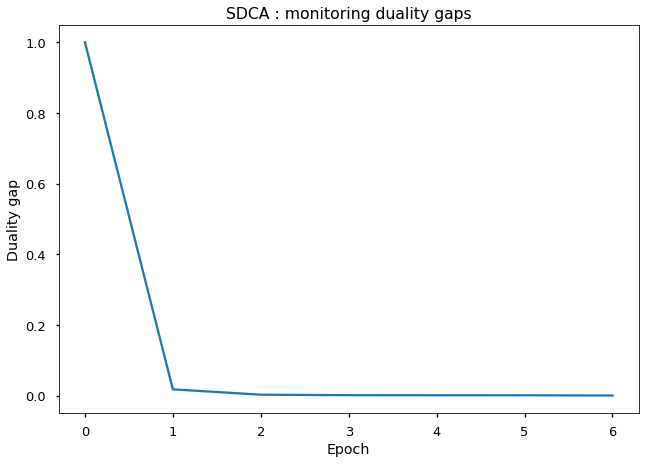

In [149]:
# Plots duality gap
plt.plot(gaps_sdca)
plt.title("SDCA : monitoring duality gaps")
plt.ylabel("Duality gap")
plt.xlabel("Epoch")
plt.savefig(output_path + "Noisy_Duality_SGD.svg")

In [55]:
# SDCA without the first SGD epoch
w_sdca, alpha_sdca, losses_sdca, perfs_sdca, gaps_sdca, scores_sdca = sdca_perm(alpha0, 
                                                                           xtrain, 
                                                                           ytrain, 
                                                                           lamb, 
                                                                           nepochs_sdca, 
                                                                           0.015, 
                                                                           sgd_first=False, 
                                                                           xtest=xtest, 
                                                                           ytest=ytest)

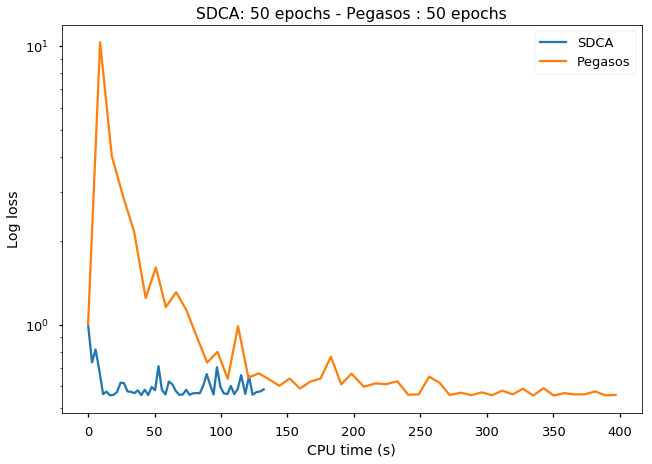

In [56]:
# Plot the losses in the case SDCA is run without SGD as first epoch
plt.semilogy(np.cumsum(perfs_sdca), losses_sdca, label="SDCA")
plt.semilogy(np.cumsum(perfs_pegasos), losses_pegasos, label="Pegasos")
plt.ylabel("Log loss")
plt.xlabel("CPU time (s)")
plt.legend()
plt.title("SDCA: " + str(nepochs_sdca) + " epochs - Pegasos : " + str(nepochs_pegasos) + " epochs")

output_path = os.getcwd() + "/Graphs/"

plt.savefig(output_path + "Noisy_Logloss.svg")
plt.show()

## PCA for dimension reduction

In [57]:
def compute_pca(xmat, ncomps):
    pca = decomposition.PCA(n_components=ncomps, whiten=True, svd_solver="randomized").fit(xmat.T)
    return pca

In [58]:
def pca_dimension_reduction(pca, xmat):
    return pca.transform(xmat.T).T

In [59]:
# Reduce dimension
ncomps = 100
pca_xtrain = compute_pca(xtrain, ncomps)
xtrain_reduced = pca_dimension_reduction(pca_xtrain, xtrain)
# We project the test images onto the eigen vectors of the PCA computed on xtrain
xtest_reduced = pca_dimension_reduction(pca_xtrain, xtest)
components = pca_xtrain.components_.T
projected = np.dot(components, xtrain_reduced)

In [63]:
neutrophils_transformed = data_from_label(projected, ytrain, 1)
neutrophils = data_from_label(xtrain, ytrain, 1)
lymphocytes_transformed = data_from_label(projected, ytrain, -1)

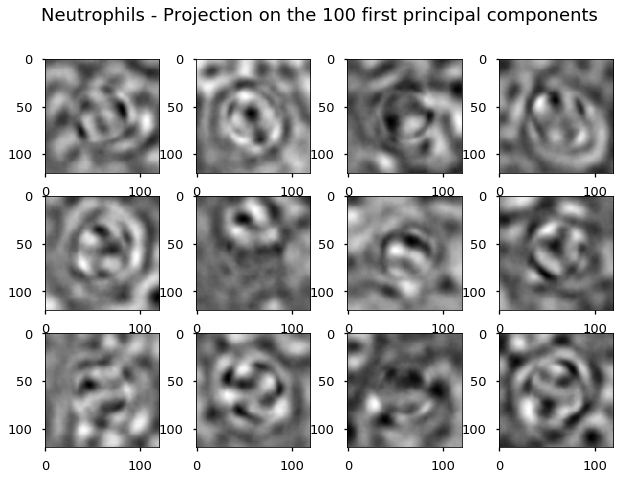

In [67]:
# Plot some examples of PCA transformed cropped neutrophils images
fig, axes = plt.subplots(3, 4)
for i in range(0, 4):
    for j in range(0, 3):
        axes[j, i].imshow(neutrophils_transformed[:, i + 4*j].reshape((120, 120)), "gray")
plt.suptitle("Neutrophils - Projection on the " + str(ncomps) + " first principal components")
fig.savefig(output_path + "Neutrophils_PCA.svg")

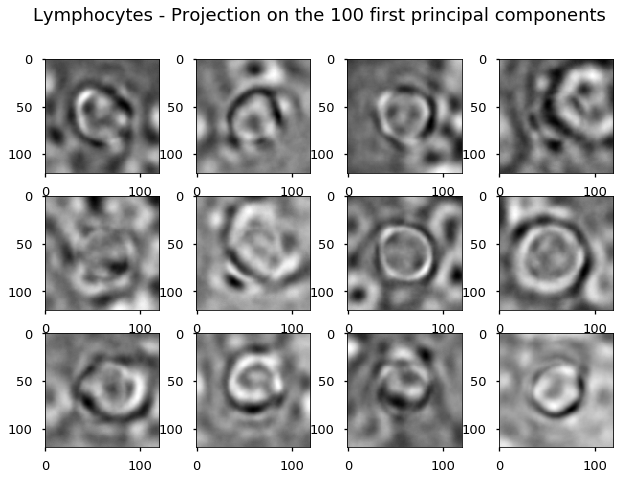

In [68]:
# Plot some examples of PCA transformed cropped lymphocytes images
fig, axes = plt.subplots(3, 4)
for i in range(0, 4):
    for j in range(0, 3):
        axes[j, i].imshow(lymphocytes_transformed[:, i + 4*j].reshape((120, 120)), "gray")
plt.suptitle("Lymphocytes - Projection on the " + str(ncomps) + " first principal components")
fig.savefig(output_path + "Lymphocytes_PCA.svg")

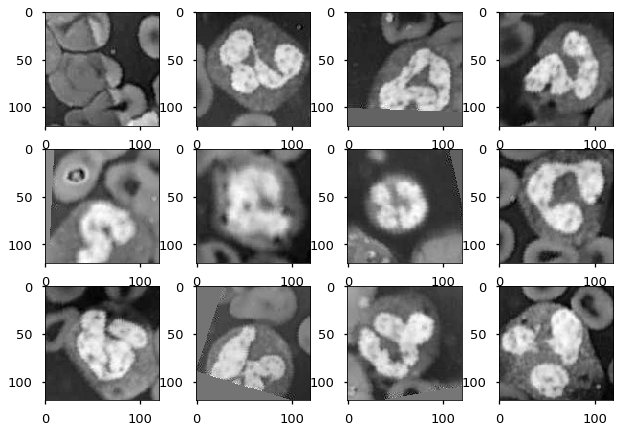

In [87]:
# Plot some examples of cropped neutrophils images
fig, axes = plt.subplots(3, 4)
for i in range(0, 4):
    for j in range(0, 3):
        axes[j, i].imshow(neutrophils[:, i + 4*j].reshape((120, 120)), "gray")
# fig.savefig(output_path + "Neutrophils.svg")

In [153]:
lamb = 1.8
d = xtrain_reduced.shape[0]
n = xtrain_reduced.shape[1]
alpha0 = np.zeros((n, ))
w_pegasos = np.zeros((d, ))
nepochs_sdca = 10
nepochs_pegasos = 20
minibatch_pegasos = 100

# SDCA epochs
w_sdca, alpha_sdca, losses_sdca, perfs_sdca, gaps_sdca, scores_sdca = sdca_perm(alpha0, 
                                                                                xtrain_reduced, 
                                                                                ytrain, 
                                                                                lamb, 
                                                                                nepochs_sdca, 
                                                                                0.00001, 
                                                                                sgd_first=True, 
                                                                                xtest=xtest_reduced, 
                                                                                ytest=ytest)
print(np.sum(perfs_sdca))

# Pegasos
losses_pegasos, perfs_pegasos, scores_pegasos= pegasos_algorithm(w_pegasos, xtrain_reduced, ytrain, 
                                                  lamb, minibatch_pegasos, nepochs_pegasos, 
                                                  xtest=xtest_reduced, ytest=ytest)
print(np.sum(perfs_pegasos))

2.204887
0.50104


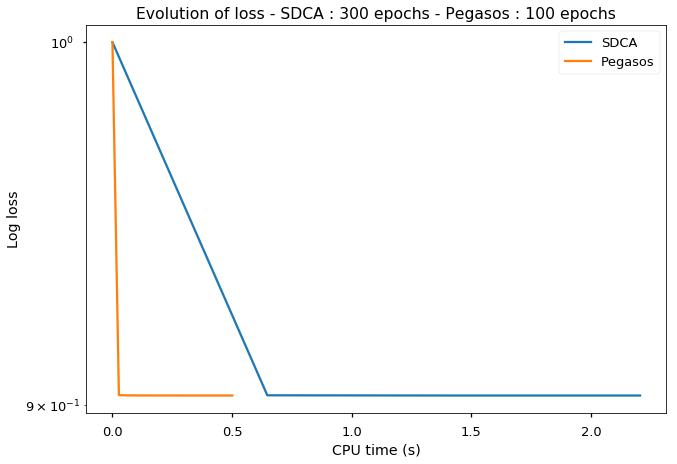

In [154]:
plt.semilogy(np.cumsum(perfs_sdca), losses_sdca, label="SDCA")
plt.semilogy(np.cumsum(perfs_pegasos), losses_pegasos, label="Pegasos")
plt.ylabel("Log loss")
plt.xlabel("CPU time (s)")
plt.legend()
plt.title("Evolution of loss - SDCA : 300 epochs - Pegasos : 100 epochs")
# plt.savefig(output_path + "Noisy_Logloss.svg")
plt.show()

In [136]:
ypred = classify(w_sdca, xtest_reduced)
print(metrics.zero_one_loss(ypred, ytest))

0.209003215434


Text(0,0.5,u'Error rate')

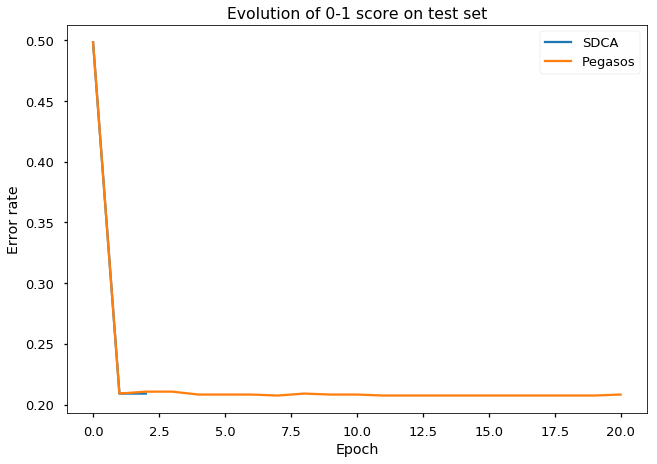

In [137]:
plt.plot(scores_sdca, label="SDCA")
plt.plot(scores_pegasos, label="Pegasos")
plt.title("Evolution of 0-1 score on test set")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error rate")
# plt.savefig(output_path + "Noisy_Test_Score.svg")

Text(0.5,1,u'Duality gap')

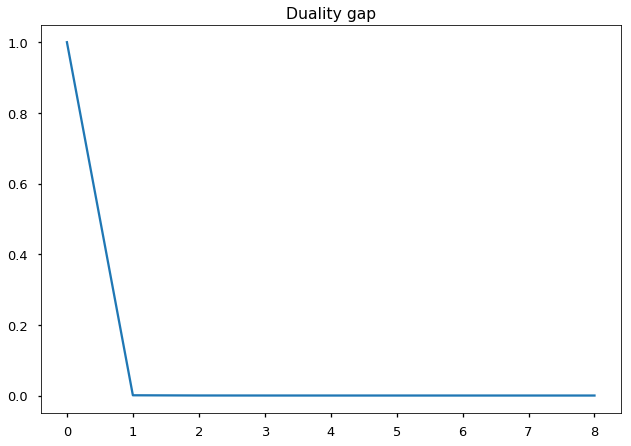

In [108]:
plt.plot(gaps_sdca)
plt.title("Duality gap")